In [ ]:
# ---------------------------
# Step 0: Imports & Setup
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")
pd.set_option('display.float_format', '{:.2f}'.format)

# Define file paths
RAW_DATA_PATH = "../data/processed/enriched_fi_data.csv"
IMPACT_LINKS_PATH = "../data/processed/enriched_impact_links.csv"
FORECAST_OUTPUT_PATH = "../models/forecast_outputs.csv"


In [ ]:
# Load datasets
fi_df = pd.read_csv(RAW_DATA_PATH, parse_dates=['observation_date'])
impact_df = pd.read_csv(IMPACT_LINKS_PATH, parse_dates=['observation_date'])

# Filter only relevant indicators for forecasting
target_indicators = ['ACC_OWNERSHIP', 'USG_P2P_COUNT', 'USG_TELEBIRR_USERS',
                     'USG_MPESA_USERS', 'USG_MPESA_ACTIVE', 'ACC_MM_ACCOUNT']

fi_df = fi_df[fi_df['indicator_code'].isin(target_indicators)]

# Quick check
fi_df.head()
impact_df.head()


,record_id,parent_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,IMP_0001,EVT_0001,impact_link,NaN,ACCESS,Telebirr effect on Account Ownership,NaN,NaN,15.00,NaN,...,increase,high,15.00,12,literature,Kenya,Example_Trainee,2025-01-20 00:00:00,NaN,Kenya M-Pesa showed +20pp over 5 years
1,IMP_0002,EVT_0001,impact_link,NaN,USAGE,Telebirr effect on Telebirr Users,NaN,NaN,NaN,NaN,...,increase,high,NaN,3,empirical,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Direct subscriber acquisition
2,IMP_0003,EVT_0001,impact_link,NaN,USAGE,Telebirr effect on P2P Transactions,NaN,NaN,25.00,NaN,...,increase,high,25.00,6,empirical,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,New digital payment channel
3,IMP_0004,EVT_0002,impact_link,NaN,ACCESS,Safaricom effect on 4G Coverage,NaN,NaN,15.00,NaN,...,increase,medium,15.00,12,empirical,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Network investment from competition
4,IMP_0005,EVT_0002,impact_link,NaN,AFFORDABILITY,Safaricom effect on Data Affordability,NaN,NaN,-20.00,NaN,...,decrease,medium,-20.00,12,literature,Rwanda,Example_Trainee,2025-01-20 00:00:00,NaN,Competition typically reduces prices


In [3]:
# Aggregate by year and indicator
fi_df['year'] = fi_df['observation_date'].dt.year
historical_ts = fi_df.groupby(['year', 'indicator_code'])['value_numeric'].mean().reset_index()

# Pivot for modeling
ts_pivot = historical_ts.pivot(index='year', columns='indicator_code', values='value_numeric')
ts_pivot


indicator_code,ACC_MM_ACCOUNT,ACC_OWNERSHIP,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
year,,,,,,
2014,NaN,22.00,NaN,NaN,NaN,NaN
2017,NaN,35.00,NaN,NaN,NaN,NaN
2021,4.70,46.00,NaN,NaN,NaN,NaN
2024,9.45,49.00,7100000.00,10800000.00,49700000.00,NaN
2025,NaN,70.00,NaN,NaN,128300000.00,54840000.00


In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare forecast years
forecast_years = np.array([2025, 2026, 2027]).reshape(-1, 1)

baseline_forecasts = {}

for indicator in target_indicators:
    # Historical data
    ts = ts_pivot[[indicator]].dropna()
    X = ts.index.values.reshape(-1, 1)
    y = ts[indicator].values

    # Fit linear trend
    model = LinearRegression()
    model.fit(X, y)

    # Forecast baseline
    baseline_forecasts[indicator] = model.predict(forecast_years)

baseline_forecasts_df = pd.DataFrame(baseline_forecasts, index=[2025, 2026, 2027])
baseline_forecasts_df


,ACC_OWNERSHIP,USG_P2P_COUNT,USG_TELEBIRR_USERS,USG_MPESA_USERS,USG_MPESA_ACTIVE,ACC_MM_ACCOUNT
2025,61.58,128300000.00,54840000.00,10800000.00,7100000.00,11.03
2026,65.15,206900000.00,54840000.00,10800000.00,7100000.00,12.62
2027,68.73,285500000.00,54840000.00,10800000.00,7100000.00,14.20


In [ ]:
# Filter high-confidence, relevant event impacts
impact_df_filtered = impact_df[impact_df['related_indicator'].isin(target_indicators)]
impact_df_filtered = impact_df_filtered[impact_df_filtered['confidence'].isin(['high', 'medium'])]

# Initialize event-augmented forecasts with baseline
event_aug_df = baseline_forecasts_df.copy()

# Apply lagged event effects
for idx, row in impact_df_filtered.iterrows():
    indicator = row['related_indicator']
    impact = row['impact_estimate']  # numeric effect (percentage or count)
    lag_years = int(np.ceil(row['lag_months']/12)) if not np.isnan(row['lag_months']) else 0
    event_year = row['observation_date'].year + lag_years

    # Apply to forecast years
    for fy in forecast_years.flatten():
        if fy >= event_year:
            event_aug_df.at[fy, indicator] += impact


In [7]:
# Scenarios: optimistic, base, pessimistic
scenario_df = pd.DataFrame(index=forecast_years.flatten())

# Base scenario = event-augmented
scenario_df['ACC_OWNERSHIP_base'] = event_aug_df['ACC_OWNERSHIP']
scenario_df['USG_P2P_COUNT_base'] = event_aug_df['USG_P2P_COUNT']

# Optimistic = +10% effect boost
scenario_df['ACC_OWNERSHIP_optimistic'] = event_aug_df['ACC_OWNERSHIP'] * 1.05
scenario_df['USG_P2P_COUNT_optimistic'] = event_aug_df['USG_P2P_COUNT'] * 1.10

# Pessimistic = -10% effect reduction
scenario_df['ACC_OWNERSHIP_pessimistic'] = event_aug_df['ACC_OWNERSHIP'] * 0.95
scenario_df['USG_P2P_COUNT_pessimistic'] = event_aug_df['USG_P2P_COUNT'] * 0.90

scenario_df


,ACC_OWNERSHIP_base,USG_P2P_COUNT_base,ACC_OWNERSHIP_optimistic,USG_P2P_COUNT_optimistic,ACC_OWNERSHIP_pessimistic,USG_P2P_COUNT_pessimistic
2025,76.58,128300025.00,80.40,141130027.50,72.75,115470022.50
2026,90.15,206900050.00,94.66,227590055.00,85.65,186210045.00
2027,93.73,285500050.00,98.42,314050055.00,89.05,256950045.00


In [8]:
# Simple CI from linear regression residuals
ci_df = pd.DataFrame(index=forecast_years.flatten())

for indicator in target_indicators:
    ts = ts_pivot[[indicator]].dropna()
    X = ts.index.values.reshape(-1,1)
    y = ts[indicator].values
    model = LinearRegression().fit(X, y)
    pred = model.predict(forecast_years)
    resid = y - model.predict(X)
    se = np.std(resid)
    ci_df[f'{indicator}_lower'] = pred - 1.96*se
    ci_df[f'{indicator}_upper'] = pred + 1.96*se

ci_df


,ACC_OWNERSHIP_lower,ACC_OWNERSHIP_upper,USG_P2P_COUNT_lower,USG_P2P_COUNT_upper,USG_TELEBIRR_USERS_lower,USG_TELEBIRR_USERS_upper,USG_MPESA_USERS_lower,USG_MPESA_USERS_upper,USG_MPESA_ACTIVE_lower,USG_MPESA_ACTIVE_upper,ACC_MM_ACCOUNT_lower,ACC_MM_ACCOUNT_upper
2025,50.57,72.59,128300000.00,128300000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,11.03,11.03
2026,54.14,76.16,206900000.00,206900000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,12.62,12.62
2027,57.72,79.74,285500000.00,285500000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,14.20,14.20


In [9]:
forecast_outputs = pd.concat([event_aug_df, scenario_df, ci_df], axis=1)
forecast_outputs.to_csv(FORECAST_OUTPUT_PATH)
forecast_outputs


,ACC_OWNERSHIP,USG_P2P_COUNT,USG_TELEBIRR_USERS,USG_MPESA_USERS,USG_MPESA_ACTIVE,ACC_MM_ACCOUNT,ACC_OWNERSHIP_base,USG_P2P_COUNT_base,ACC_OWNERSHIP_optimistic,USG_P2P_COUNT_optimistic,...,USG_P2P_COUNT_lower,USG_P2P_COUNT_upper,USG_TELEBIRR_USERS_lower,USG_TELEBIRR_USERS_upper,USG_MPESA_USERS_lower,USG_MPESA_USERS_upper,USG_MPESA_ACTIVE_lower,USG_MPESA_ACTIVE_upper,ACC_MM_ACCOUNT_lower,ACC_MM_ACCOUNT_upper
2025,76.58,128300025.00,NaN,NaN,7100000.00,16.03,76.58,128300025.00,80.40,141130027.50,...,128300000.00,128300000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,11.03,11.03
2026,90.15,206900050.00,NaN,NaN,7100015.00,17.62,90.15,206900050.00,94.66,227590055.00,...,206900000.00,206900000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,12.62,12.62
2027,93.73,285500050.00,NaN,NaN,7100015.00,19.20,93.73,285500050.00,98.42,314050055.00,...,285500000.00,285500000.00,54840000.00,54840000.00,10800000.00,10800000.00,7100000.00,7100000.00,14.20,14.20


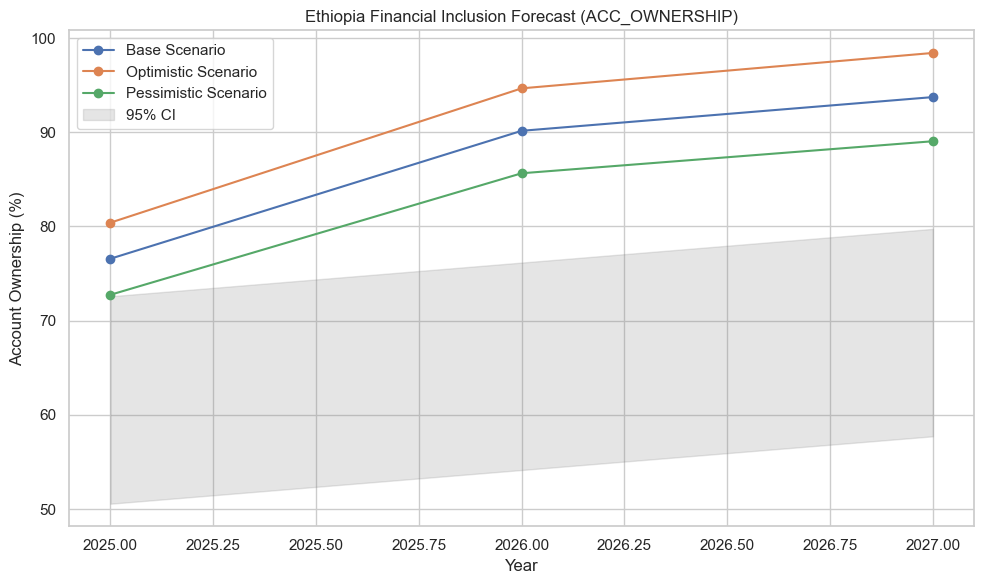

In [ ]:
plt.figure(figsize=(10,6))
years = forecast_outputs.index

# Plot Account Ownership Scenarios
plt.plot(years, forecast_outputs['ACC_OWNERSHIP_base'], label='Base Scenario', marker='o')
plt.plot(years, forecast_outputs['ACC_OWNERSHIP_optimistic'], label='Optimistic Scenario', marker='o')
plt.plot(years, forecast_outputs['ACC_OWNERSHIP_pessimistic'], label='Pessimistic Scenario', marker='o')

# CI shading
plt.fill_between(years, ci_df['ACC_OWNERSHIP_lower'], ci_df['ACC_OWNERSHIP_upper'],
                 color='gray', alpha=0.2, label='95% CI')

plt.title('Ethiopia Financial Inclusion Forecast (ACC_OWNERSHIP)')
plt.xlabel('Year')
plt.ylabel('Account Ownership (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Repeat similarly for USG_P2P_COUNT or other indicators
